## Dataset

In [ ]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# get data
# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/

zip_path = tf.keras.utils.get_file( # 
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

print(zip_path)

csv_path, _ = os.path.splitext(zip_path) # https://docs.python.org/3/library/os.path.html
print(csv_path)

13574144/13568290 [==============================] - 0s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
/root/.keras/datasets/jena_climate_2009_2016.csv


In [ ]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [ ]:
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Observations:
1. One reading every 10 mins
2. 1 day = 6*24 = 144 readings
3. 5 days = 144*5 = 720 readings


**Forecasting task:**  Predict temperature (in deg C) in the future.




In [ ]:
# univariate data: Temp vs Time

uni_data_df = df['T (degC)']
uni_data_df.index = df['Date Time']
uni_data_df.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

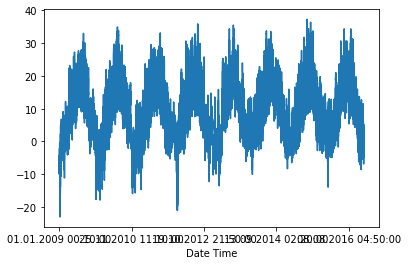

In [ ]:
uni_data_df.plot()

In [ ]:
uni_data = uni_data_df.values # numpy ndarray from pandas

In [ ]:
TRAIN_SPLIT = 300000 # First 300000 obs will be used as train data and rest as test data.
# 300,000 => ~2100 days worth of training data


tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


## Moving window average

### Pose a simple problem: 
Given last 'k' values of temp-observations (only one feature <=> univariate), predict the next observation

### MWA: 
Average the previous k values to predict the next value.

In [ ]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)



(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [ ]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


In [ ]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

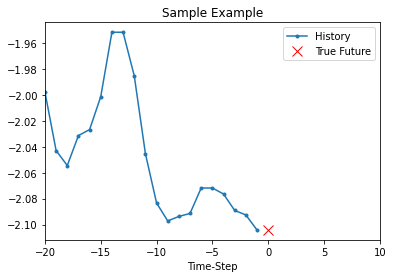

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

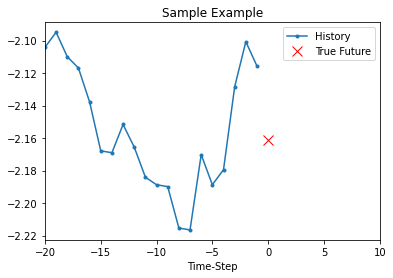

In [ ]:
i=20
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

In [ ]:
def mwa(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

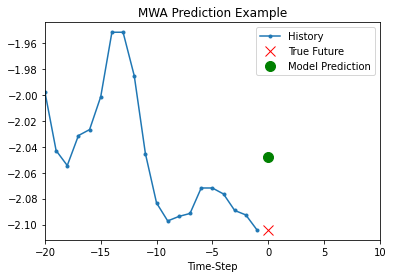

In [ ]:
i=0
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

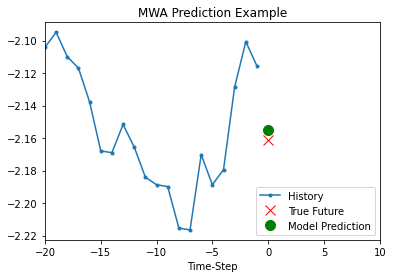

In [ ]:
i=20
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

## Univariate time-series forecasting

-  Features from the history: only temperature => univariate

- Problem definition: Given last "k=20" values of temp, predict the next temp value.

In [ ]:
# TF Dataset preperation.
BATCH_SIZE = 256 # bacth size in batch-SGD/variants.
BUFFER_SIZE = 10000 # for shuffling the dataset.

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)


<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


In [ ]:
# MODEL:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 100

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1098 - val_loss: 0.0338
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0356 - val_loss: 0.0262
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0322 - val_loss: 0.0240
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0272 - val_loss: 0.0203
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0225 - val_loss: 0.0185
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0233 - val_loss: 0.0187
Epoch 7/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0222 - val_loss: 0.0174
Epoch 8/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0206 - val_loss: 0.0153
Epoch 9/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0195 - val_loss: 0.0153
Epoch 10/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0173 - val_l

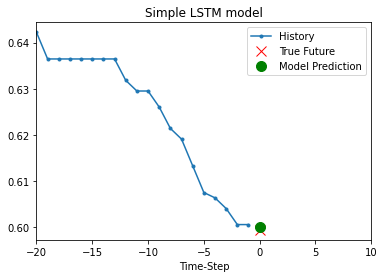

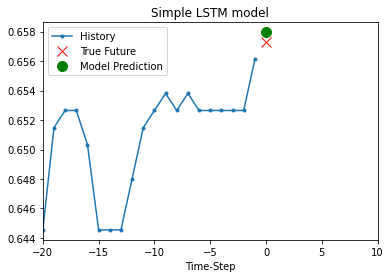

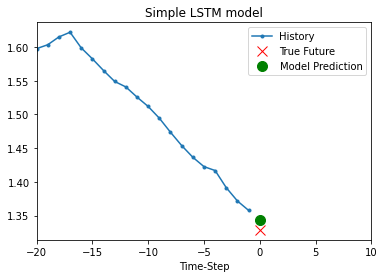

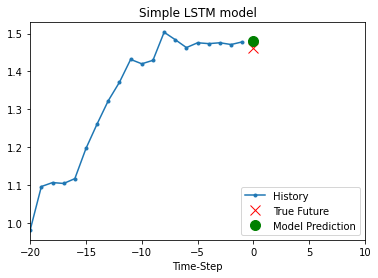

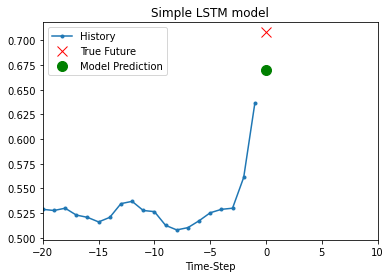

In [ ]:
for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Multi-variate & single-step forecasting

- Problem definition: Given three features (p, T, rho) at each time stamp in the past, predict the temperature at a single time-stamp in the future.

In [ ]:
# Features
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd12b0a9278>,
      dtype=object)

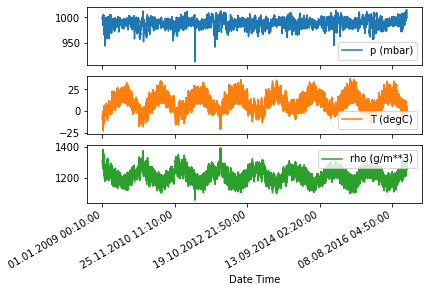

In [ ]:
features.plot(subplots=True)

In [ ]:
# Standardize data

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [ ]:
# Same as univariate_data above.

# New params:
# step: instead of taking data for each 10min, do you want to generate data once evrey 6 steps (60min)
# single_step: lables from single timestamp or multiple timesteps.


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [ ]:
# Generate data
past_history = 720 # 720*10 mins 
future_target = 72 # 72*10 mins
STEP = 6 # one obs every 6X10min = 60 min => 1 hr

# past history: 7200 mins => 120 hrs, sampling at one sample evry hours 
# future_target: 720 mins = > 12 hrs in the future, not next hour

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(299280, 120, 3)
(299280,)


In [ ]:
#TF dataset
BATCH_SIZE = 256 # bacth size in batch-SGD/variants.
BUFFER_SIZE = 10000 # for shuffling the dataset.

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>


In [ ]:
STEPS_PER_EPOCH = 200
# Model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

# Train
single_step_history = single_step_model.fit(train_data_single, epochs=100,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/100
200/200 [==============================] - 7s 33ms/step - loss: 0.3183 - val_loss: 0.2502
Epoch 2/100
200/200 [==============================] - 6s 31ms/step - loss: 0.2526 - val_loss: 0.2387
Epoch 3/100
200/200 [==============================] - 6s 31ms/step - loss: 0.2575 - val_loss: 0.2633
Epoch 4/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2528 - val_loss: 0.2315
Epoch 5/100
200/200 [==============================] - 6s 31ms/step - loss: 0.2242 - val_loss: 0.2328
Epoch 6/100
200/200 [==============================] - 6s 31ms/step - loss: 0.2389 - val_loss: 0.2796
Epoch 7/100
200/200 [==============================] - 6s 30ms/step - loss: 0.2425 - val_loss: 0.2430
Epoch 8/100
200/200 [==============================] - 6s 30ms/step - loss: 0.2381 - val_loss: 0.2449
Epoch 9/100
200/200 [==============================] - 6s 29ms/step - loss: 0.2451 - val_loss: 0.2432
Epoch 10/100
200/200 [==============================] - 6s 28ms/step - loss: 0.236

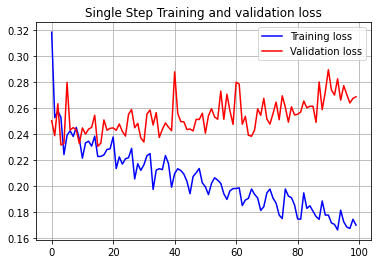

In [ ]:
# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

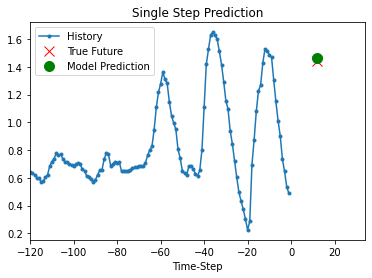

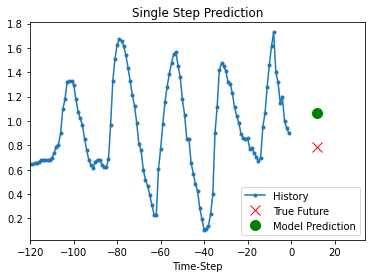

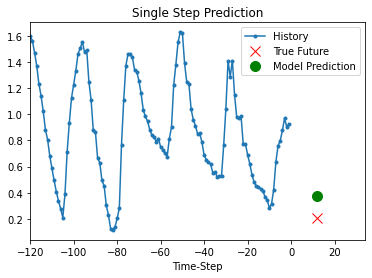

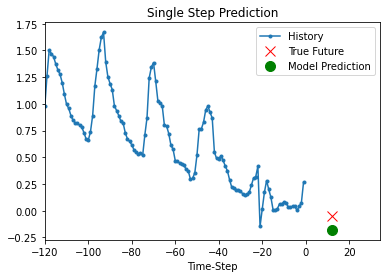

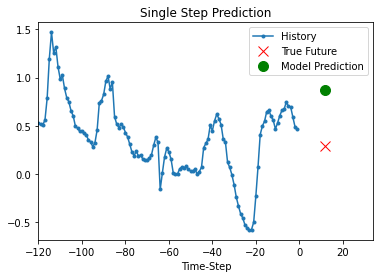

In [ ]:
# plot time series and predicted values

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


## Multi-variate & multi-step forecasting
- Generate multiple future values of temperature

In [ ]:
# single_step=FALSE default value

future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(299280, 120, 3)
(299280, 72)
(119759, 120, 3)
(119759, 72)


In [ ]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

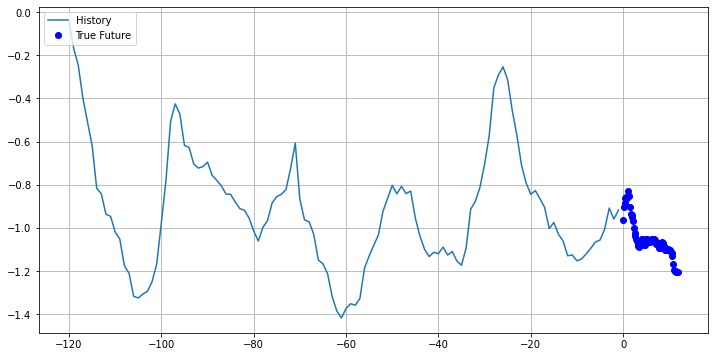

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(72, activation='elu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 128)          67584     
_________________________________________________________________
lstm_3 (LSTM)                (None, 72)                57888     
_________________________________________________________________
dense_2 (Dense)              (None, 72)                5256      
Total params: 130,728
Trainable params: 130,728
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile.
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

# Train.
multi_step_history = multi_step_model.fit(train_data_multi, epochs=50,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/50
200/200 [==============================] - 74s 368ms/step - loss: 0.4571 - val_loss: 0.2960
Epoch 2/50
200/200 [==============================] - 74s 371ms/step - loss: 0.3786 - val_loss: 0.2831
Epoch 3/50
200/200 [==============================] - 76s 380ms/step - loss: 0.3789 - val_loss: 0.2875
Epoch 4/50
200/200 [==============================] - 75s 374ms/step - loss: 0.3524 - val_loss: 0.2663
Epoch 5/50
200/200 [==============================] - 74s 371ms/step - loss: 0.2557 - val_loss: 0.2296
Epoch 6/50
200/200 [==============================] - 73s 366ms/step - loss: 0.2423 - val_loss: 0.2398
Epoch 7/50
200/200 [==============================] - 73s 365ms/step - loss: 0.2232 - val_loss: 0.2243
Epoch 8/50
200/200 [==============================] - 73s 363ms/step - loss: 0.2174 - val_loss: 0.2137
Epoch 9/50
200/200 [==============================] - 73s 364ms/step - loss: 0.2188 - val_loss: 0.1979
Epoch 10/50
200/200 [==============================] - 74s 368ms/step - l

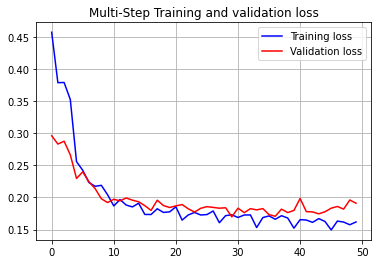

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

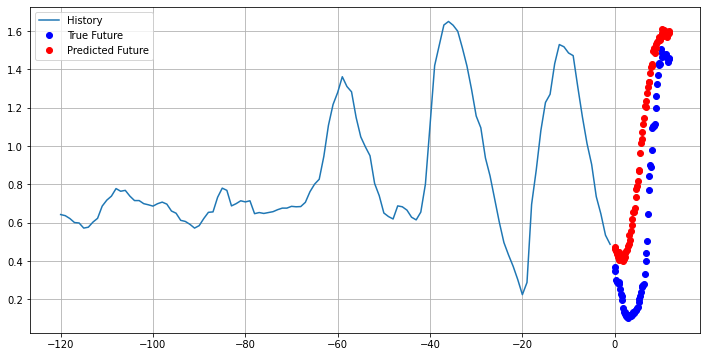

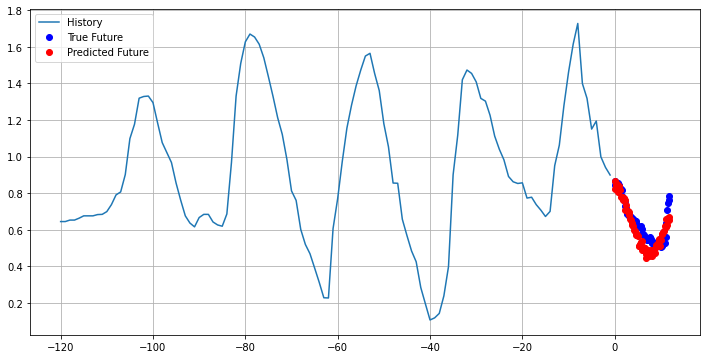

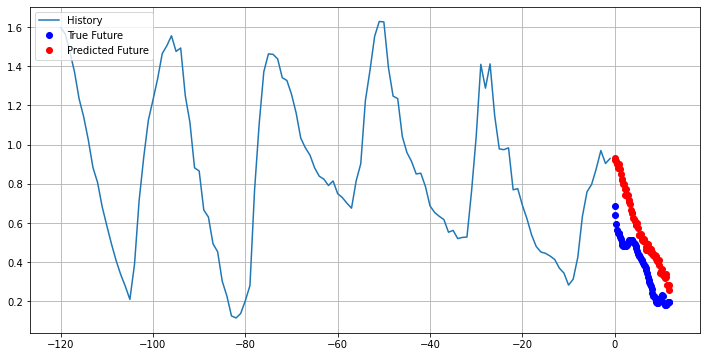

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])